# Setting

In [1]:
from pf_utils import PortfolioManager as PM 
from pf_utils import BacktestManager, FinancialRatios, PortfolioBuilder
from pf_widgets import WidgetUniverse, WidgetTransaction

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
path_data = 'data'
path_tran = 'transaction'

In [3]:
file_bt_price = 'bt_kospi200_prices_040102_241023.csv'
file_bt_ratio = 'bt_kospi200_ratios_040131_240930.csv'

# Data

## Price

In [24]:
k200 = PM.create_universe('UV_K200', file=file_bt_price)

426 assets from 2004-01-02 to 2024-10-23 uploaded.
df_prices loaded


In [25]:
df_k200 = k200.df_prices.ffill()
assetnames_k200 = k200.get_names()

ERROR from get_names: '060000'


## Ratios

In [26]:
WidgetUniverse

In [27]:
file = file_bt_ratio
fr = FinancialRatios(file, path_data)

Financial ratios of 426 stocks from 2004-01-31 to 2024-09-30 loaded


In [28]:
#fr.calc_rank(metrics='PER', date='start', topn=None)
fr.calc_rank(metrics='PER', topn=None)

Ranking score of PER on 2024-09-30


ticker
005440    0.000000
085310    0.003436
007860    0.006873
001230    0.010309
010060    0.013746
            ...   
003670    0.986254
329180    0.989691
450080    0.993127
377300    0.996564
004800    1.000000
Name: PER, Length: 292, dtype: float64

In [29]:
#fr.calc_historical()
fr.calc_historical(['PER', 'PBR'])

Historical of PER+PBR ranking score created


ticker  date      
005930  2004-01-31    1.669885
        2004-02-29    1.763447
        2004-03-31    1.759707
        2004-04-30    1.782042
        2004-05-31    1.773187
                        ...   
009970  2024-05-31    0.412358
        2024-06-30    0.395185
        2024-07-31    0.376691
        2024-08-31    0.381042
        2024-09-30    0.412514
Name: PER, Length: 87257, dtype: float64

In [30]:
#fr.get_stats(stats_daily=False)
fr.get_stats()

Returning stats of daily averages


,BPS,PER,PBR,EPS,DIV,DPS
start,2004-01-31,2004-01-31,2004-01-31,2004-01-31,2004-01-31,2004-01-31
end,2024-09-30,2024-09-30,2024-09-30,2024-09-30,2024-09-30,2024-09-30
mean,64684.1,35.8,1.6,5342.9,1.7,849.3
std,17561.2,26.8,0.4,1537.8,0.6,251.7


## Reshape
Interpolate & Reshape for backtesting

In [31]:
df_p = fr.util_reshape(df_k200)

fratios_dict = dict()
for r in ['PER', 'PBR']:
    df_r = fr.interpolate(df_p, r)
    fratios_dict[r] = fr.util_reshape(df_r, stack=False)

PER interpolated from 2004-02-02 to 2024-10-23
PBR interpolated from 2004-02-02 to 2024-10-23


# Parameter study

In [17]:
k200.get_date_range().describe()

,start date,end date,n
count,426,426,426.000000
mean,2009-02-07 17:34:38.873239552,2019-06-30 14:21:58.309859328,2392.565728
min,2004-01-02 00:00:00,2004-12-30 00:00:00,34.000000
25%,2004-01-02 00:00:00,2014-12-30 00:00:00,745.500000
50%,2005-01-03 00:00:00,2023-03-23 12:00:00,1987.000000
75%,2014-01-02 00:00:00,2024-10-23 00:00:00,3911.000000
max,2024-01-02 00:00:00,2024-10-23 00:00:00,5142.000000
std,NaN,NaN,1737.626557


In [18]:
n_val = 400
n_lb = 100
df = df_k200
df_train = df.iloc[:-n_val]
df_val = df.iloc[-n_val-n_lb:]

In [19]:
kwargs_bm = dict(
    initial_capital = 1e8,
    commissions = 0,
    align_axis = None, 
    days_in_year = 241,
    asset_names = assetnames_k200
)

## Cross-validate

In [20]:
from itertools import product

p_args = dict(
    #p_fr = ['PER', 'PBR', 'PER+PBR'],
    p_fr = ['PER'],
    p_ast = [5, 10, 20, 30],
    p_freq = ['6m', '1y', '2y'],
    p_lb = [0, '1w', '2w', '1m', '2m']
)
p_comb = list(product(*p_args.values()))
params = [{'name':'{}:a{}/f{}/lb{}'.format(*x),
           'df_ratio':x[0], 'n_tickers':x[1], 'freq':x[2], 'lookback':x[3]} 
          for x in p_comb]
params[0]

{'name': 'PER:a5/f6m/lb0',
 'df_ratio': 'PER',
 'n_assets': 5,
 'freq': '6m',
 'lookback': 0}

In [21]:
convert_args = lambda p: [{**x, 'df_ratio': fratios_dict[x['df_ratio']]} for x in p]

In [22]:
bm = BacktestManager(df_train, **kwargs_bm)

426 assets from 2004-01-02 to 2023-03-03 uploaded.
running self.util_check_days_in_year to check days in a year


In [23]:
kwa_list = convert_args(params)

kwargs_build = dict(
    select='F-ratio', weigh='Equally', ratio_descending=False, build_cv=True
)
bm.build_batch(*kwa_list, **kwargs_build)

60 jobs prepared for cross-validation


In [ ]:
kw_batch = dict(size_batch=10, path_batch=path_data)
bm.cross_validate(n_sample=20, **kw_batch)

## Visualize

In [4]:
file = 'param_per_k200.csv'

*Save param study*

In [40]:
f = dict(file=file, path=path_data)
df_cv = bm.get_cat_data(params, **f)

data/param_per_k2hl.csv saved
60 param sets with 18 iterations per set


*Load param study*

In [5]:
bm = BacktestManager
df_cv = bm.catplot(file, path=path_data)

Returning data/param_per_k200.csv
60 param sets with 18 iterations per set


In [6]:
y = 'cagr'
ref_val = 'KODEX200'

Returning cagr of KODEX200 from 2004-01-02 to 2023-03-03


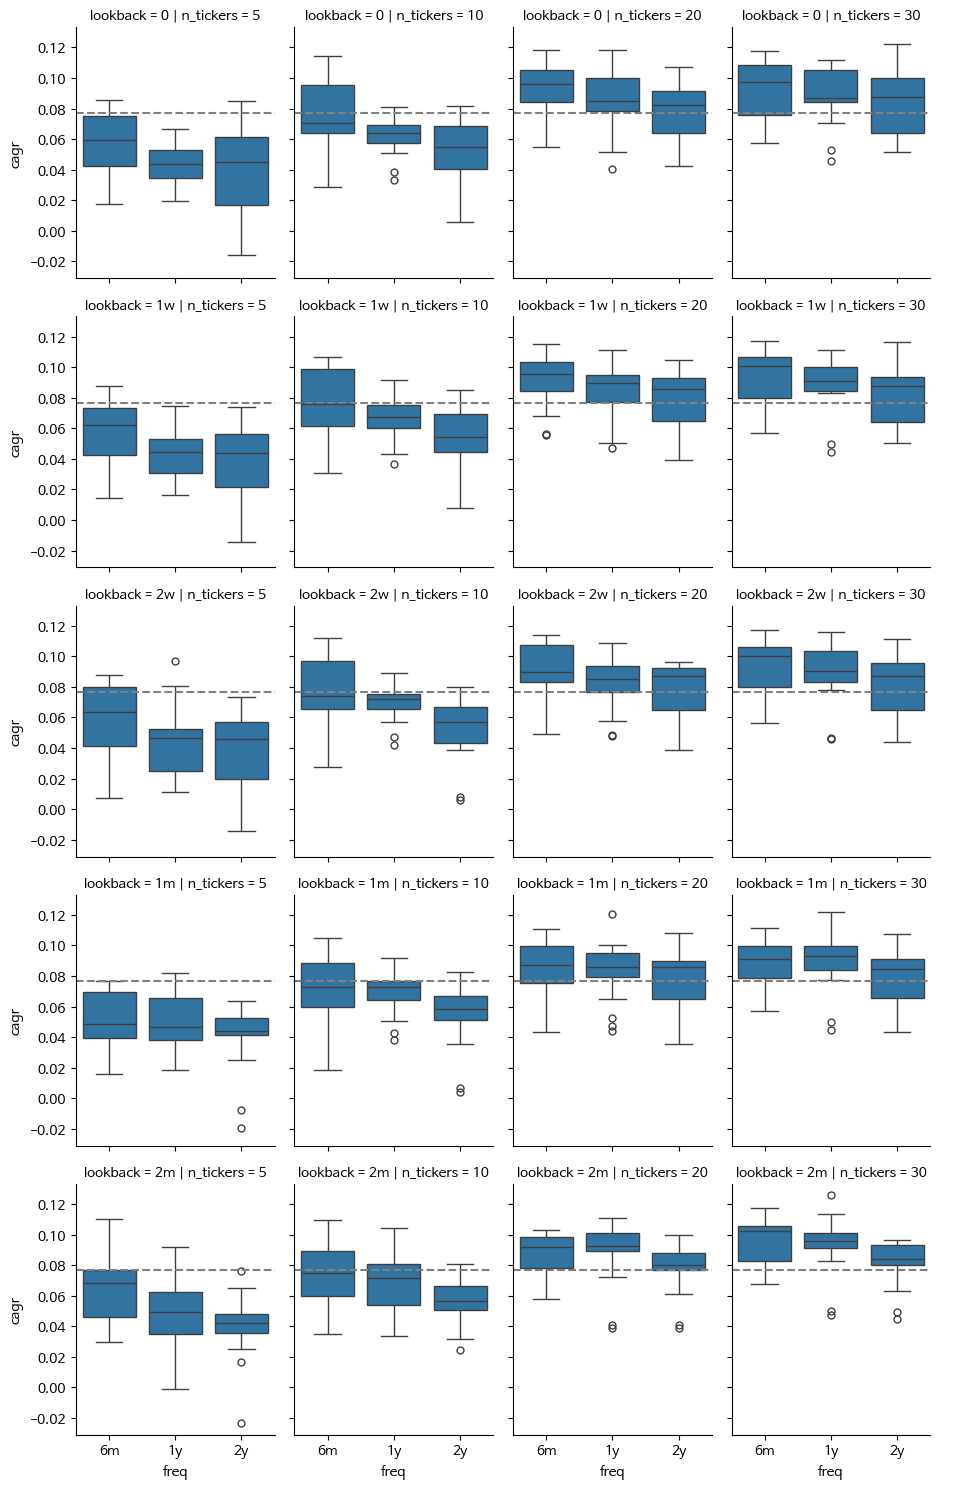

In [7]:
#kw = {'x':'lookback', 'row':'freq', 'col':'n_tickers'}
#kw = {'hue':'lookback', 'col':'freq', 'x':'n_tickers'}
#kw = {'col':'freq', 'x':'n_tickers', 'kind':'box'}
kw = {'x':'freq', 'col':'n_tickers', 'kind':'box', 'row':'lookback'}
#kw = {'x':'freq', 'col':'n_tickers', 'hue':'lookback'}

_ = bm.catplot(data=df_cv, y=y, ref_val=ref_val, height=3, aspect=.8, **kw)

## Validation

In [29]:
bm = BacktestManager(df_val, **kwargs_bm)

426 assets from 2022-10-11 to 2024-10-23 uploaded.
running self.util_check_days_in_year to check days in a year


In [30]:
bm.benchmark_ticker()

Benchmark is KODEX200


In [31]:
p_comb = [[20, '1y', '2m'], [30, '1y', '2m'], [20, '6m', '1w']]
kwa_list = [{'name':'PER:a{}/f{}'.format(*x), 
             'n_tickers':x[0], 'freq':x[1], 'lookback':x[2]} for x in p_comb]

Backtesting 4 strategies: KODEX200, PER:a20/f1y, PER:a30/f1y, PER:a20/f6m


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]

Returning stats


,KODEX200,PER:a20/f6m,PER:a30/f1y,PER:a20/f1y
start,2022-10-10,2022-10-10,2022-10-10,2022-10-10
end,2024-10-23,2024-10-23,2024-10-23,2024-10-23
total_return,0.27411,0.148782,0.146711,0.130765
cagr,0.126287,0.070465,0.069517,0.06219
calmar,0.766328,0.651488,0.884681,0.498982
max_drawdown,-0.164794,-0.108159,-0.078578,-0.124633
avg_drawdown,-0.030918,-0.021709,-0.025835,-0.029052
avg_drawdown_days,22.586207,54.153846,58.5,70.6
daily_vol,0.182857,0.121151,0.109756,0.130845
daily_sharpe,0.759752,0.637522,0.683496,0.538675


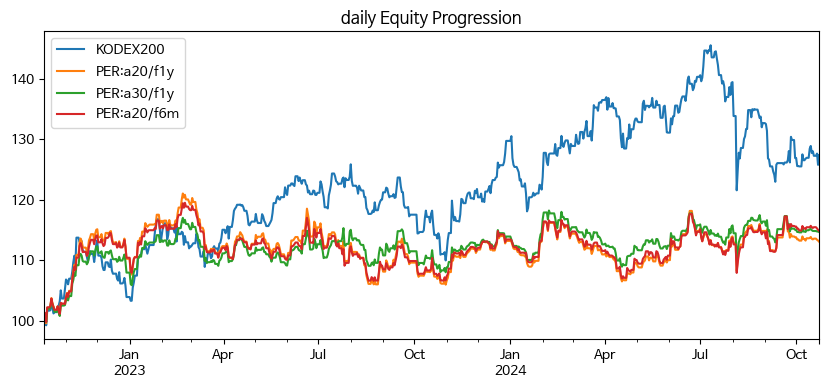

In [32]:
kwargs_build = dict(
    select='f-ratio', weigh='Equally', 
    ratio_descending=False, build_cv=False,
    df_ratio=fratios_dict['PER']
)
bm.build_batch(*kwa_list, **kwargs_build)

bm.run(stats_sort_by='cagr', figsize=(10,4))

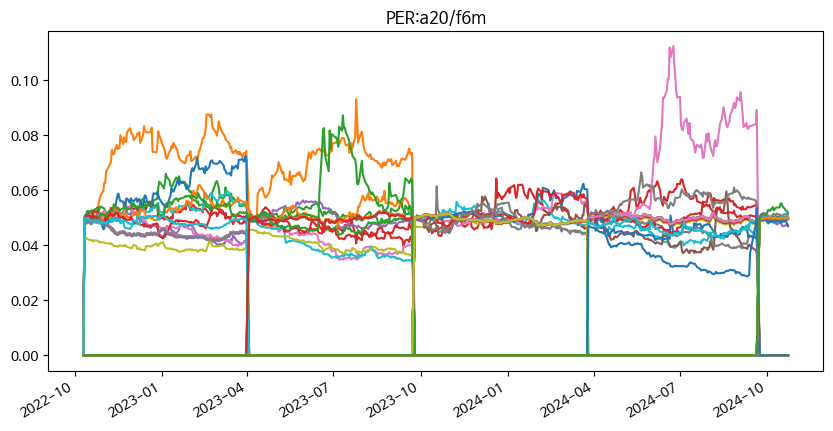

In [33]:
bm.plot_security_weights(3, legend=False)

# Transaction

*Price*

In [10]:
k200 = PM.create_universe('UV_K200')
df_k200 = k200.df_prices
assetnames_k200 = k200.get_names()

201 assets from 2021-01-04 to 2024-11-07 uploaded.
df_prices loaded


*Ratio*

In [12]:
fratio = 'PER'
file = 'kospi200_ratios'
fr = FinancialRatios(file, path_data)
df_ratio = fr.util_reshape(fratio, stack=False)

Financial ratios of 201 stocks from 2023-01-02 to 2024-11-07 loaded


In [13]:
kwargs = dict(
    name=fratio,
    method_select='f-ratio',
    sort_ascending=True,
    n_tickers = 20,
    lookback='2m',
    df_additional=df_ratio,
    method_weigh='equally',
    file='test_per.csv',
    path=path_tran,
    asset_names=assetnames_k200
)
pf_per = PortfolioBuilder(df_k200, **kwargs)

REMINDER: make sure this is 1st transaction as no records provided


*Optimized param values set in pf_data.py*

In [14]:
PM.review_strategy('PER')

{'method_select': 'F-ratio',
 'method_weigh': 'Equally',
 'sort_ascending': True,
 'n_assets': 20,
 'lookback': '2m',
 'lag': 0,
 'file': 'pf_k200_per',
 'path': 'transaction'}

In [15]:
pf_per.view_record()

ERROR: No transaction record


In [16]:
pf_per.valuate()

ERROR: No transaction record


In [17]:
# set kwargs of transaction_pipeline
WidgetTransaction

In [22]:
kwargs_trs = dict(
    date = WidgetTransaction.values(0),
    capital = WidgetTransaction.values(1),
    save = WidgetTransaction.values(2)
)

_ = pf_per.transaction_pipeline(**kwargs_trs)
pf_per.view_record()

Liquidation set to None
20 assets selected by Financial Ratio from 2024-02-02 to 2024-04-02
Weights of assets determined by Equal weights.
Mean absolute error of weights: 7 %
Portfolio value 7,154,210, Profit 1.3% on 2024-11-07
Set save=True to save transaction record


name   price  transaction  net weight weight*
date       asset                                                    
2024-04-02 011200       HMM   15700           25   25  0.050  0.0556
           137310  에스디바이오센서   11700           34   34  0.050  0.0563
           016380      KG스틸    7040           56   56  0.050  0.0558
           036460    한국가스공사   26400           15   15  0.050  0.0561
           001120   LX인터내셔널   26750           14   14  0.050  0.0530
           139480       이마트   67900            5    5  0.050  0.0481
           000880        한화   26700           14   14  0.050  0.0529
           078930        GS   47850            8    8  0.050  0.0542
           000670        영풍  468000            0    0  0.050  0.0000
           009970   영원무역홀딩스   85400            4    4  0.050  0.0484
           010060    OCI홀딩스   92700            4    4  0.050  0.0525
           111770      영원무역   41200            9    9  0.050  0.0525
           047040      대우건설    3750          106  106  0.050  0.0563
           003030    세아제강지주  228000            1    1  0.050  0.0323
           138930   BNK금융지주    7720           51   51  0.050  0.0558
           028670       팬오션    4080           98   98  0.050  0.0566
           316140    우리금융지주   14050           28   28  0.050  0.0557
           267250      HD현대   70300            5    5  0.050  0.0498
           375500     DL이앤씨   36450           10   10  0.050  0.0516
           088350      한화생명    2860          139  139  0.050  0.0563

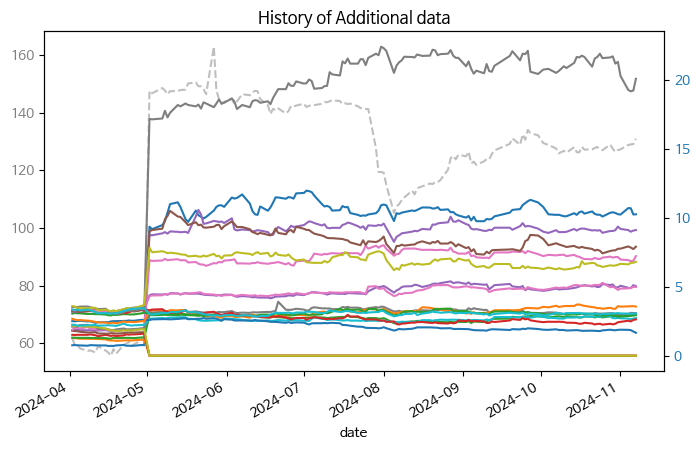

In [23]:
_ = pf_per.check_additional(plot=True, legend=False)